# PoC Drivify
The model should have a name since the PoC/MVP phase.

The name should be short and self-explanaroty. 
A suggestion for a file name:    
*state of the model and the name.ipynb*    
For example:    
*PoC_Customer_Retention.ipynb*

# 1. Overview


This section should provide a description of the problem and the model, including its purpose and what it does.


Questions to be answered:


***- What is the problem?***

It is difficult to predict the income for taxi drivers. There is a need to help drivers to optimize their income based on their availability.


***- How will this model help to solve the problem?***  


***- High-level description of the model.***

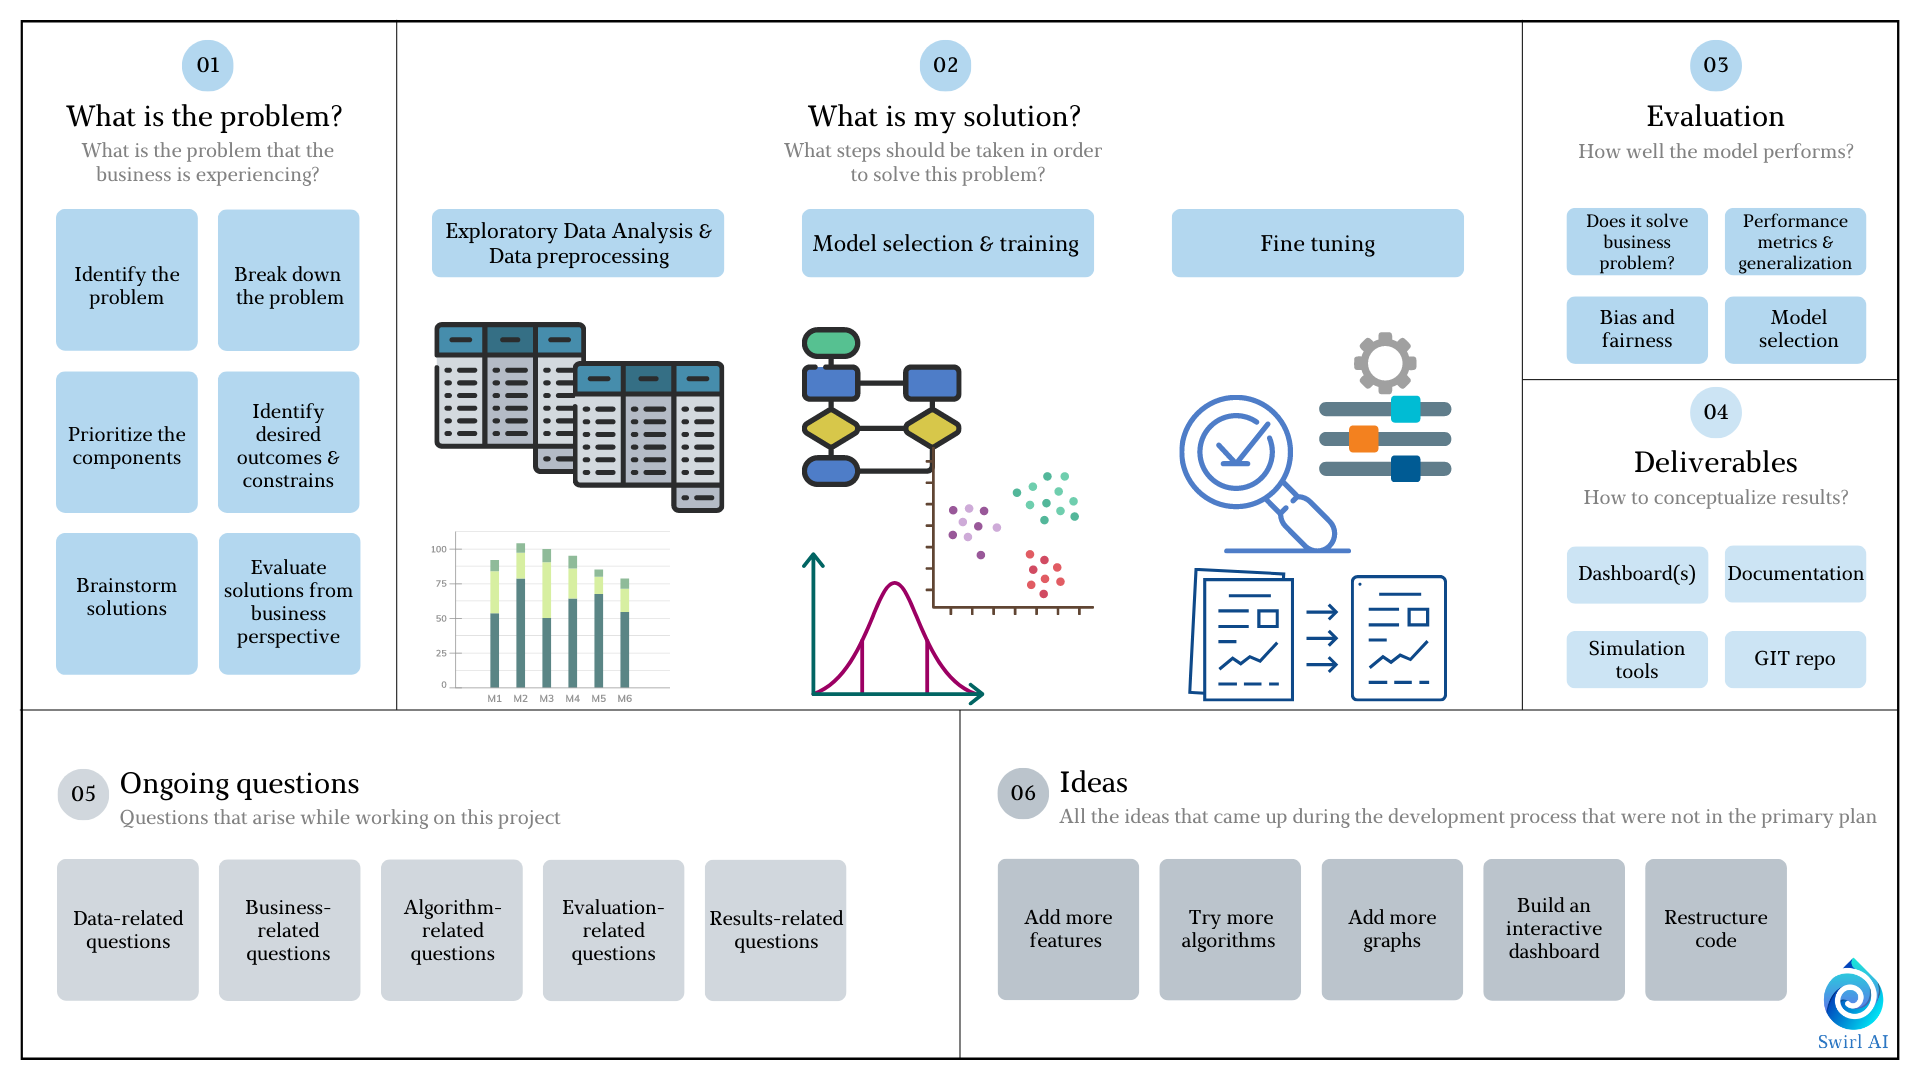

# 2. Business requirements

### 2.1 The team

Decision maker -

Data scientist -

Data engineer - 

Subject matter expert -



### 2.2 Deliverables

***PoC***, MvP, Dashboards, Datasets, etc

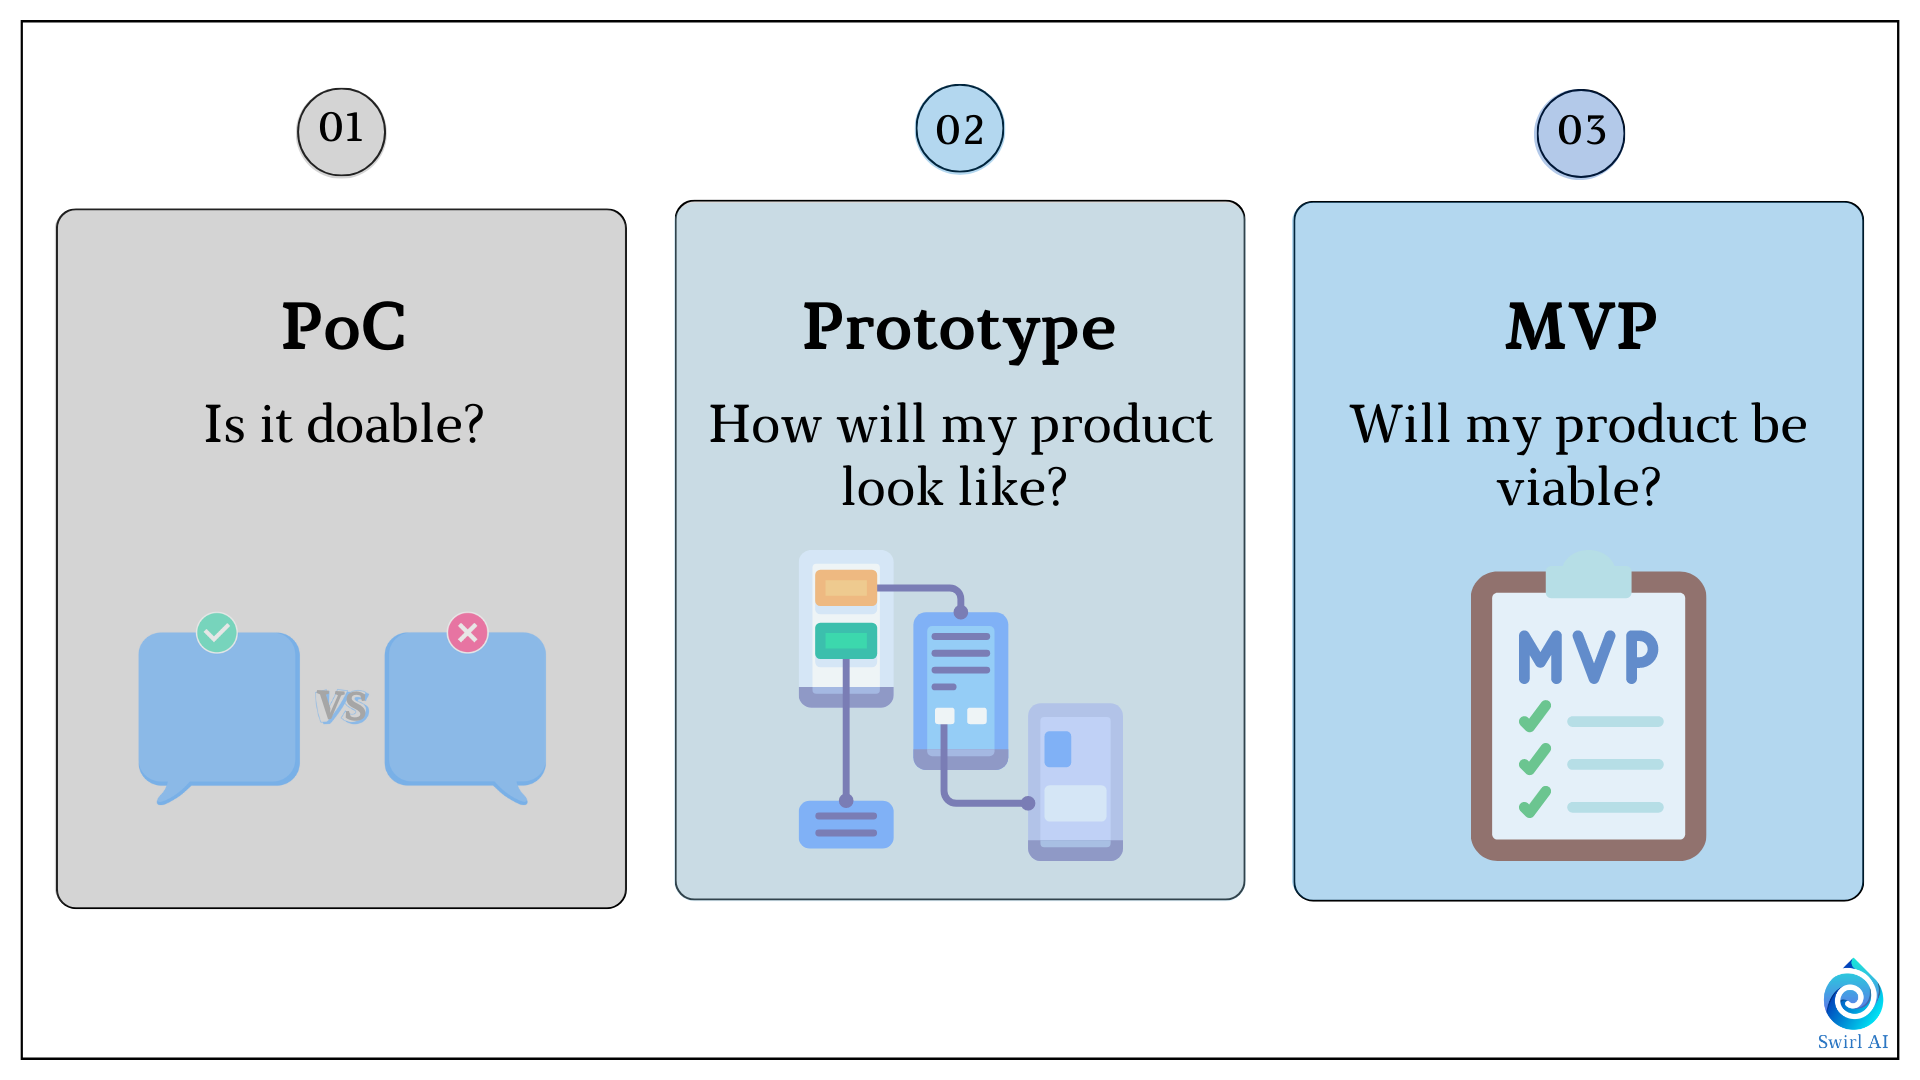

### 2.3 Logistics

*- What regular meetings do want to have?*

*- How will we track the progress?*

*- How and when and to whom will we communicate the progress externally?*

*- How will we settle disagreements?*

*- What's the escalation line?*

*- Who is going to be responsible for testing the solution and when?*



### 2.4 Target variable

***A number of weekly income, based on working days, hours, city zones.***

### 2.5 Good enough criteria set

Main principles:

1. Model creates value
2. There are no critical issues
3. Solution is considered and further improvements are not critical

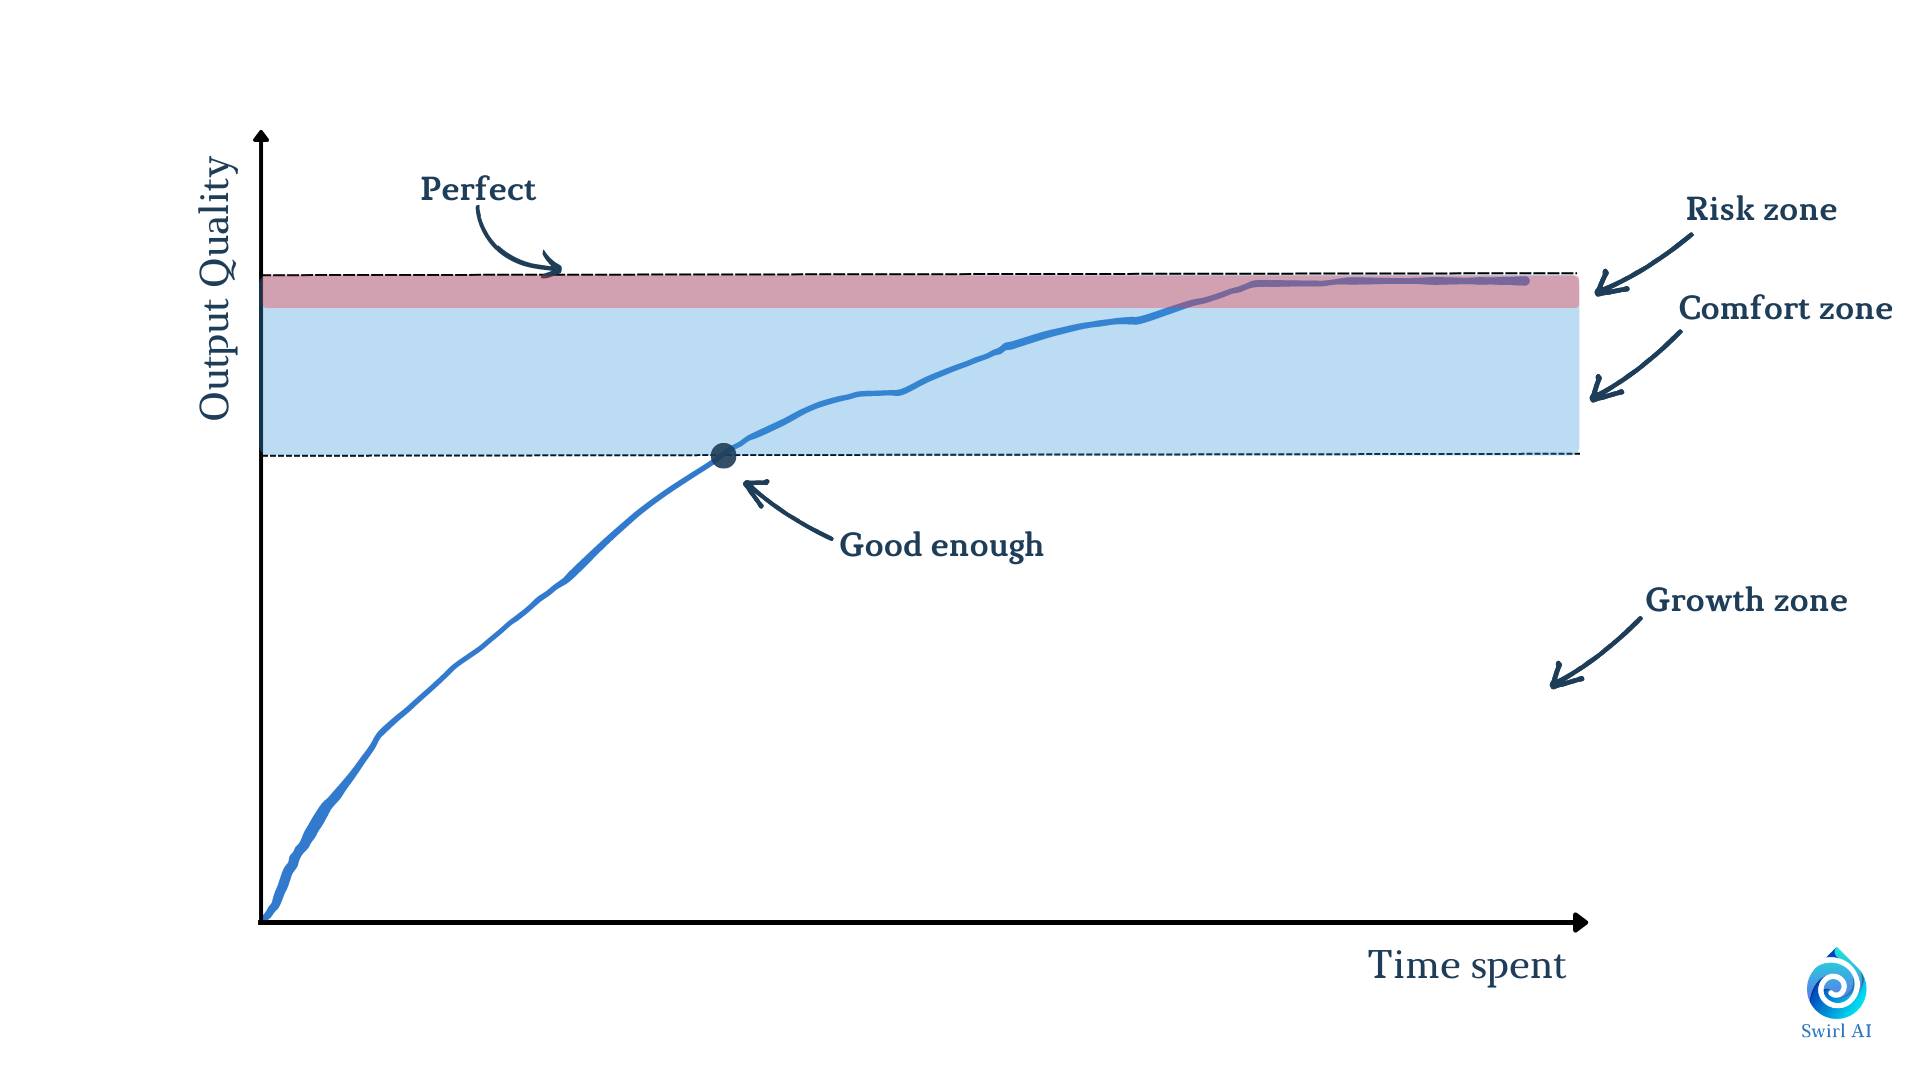

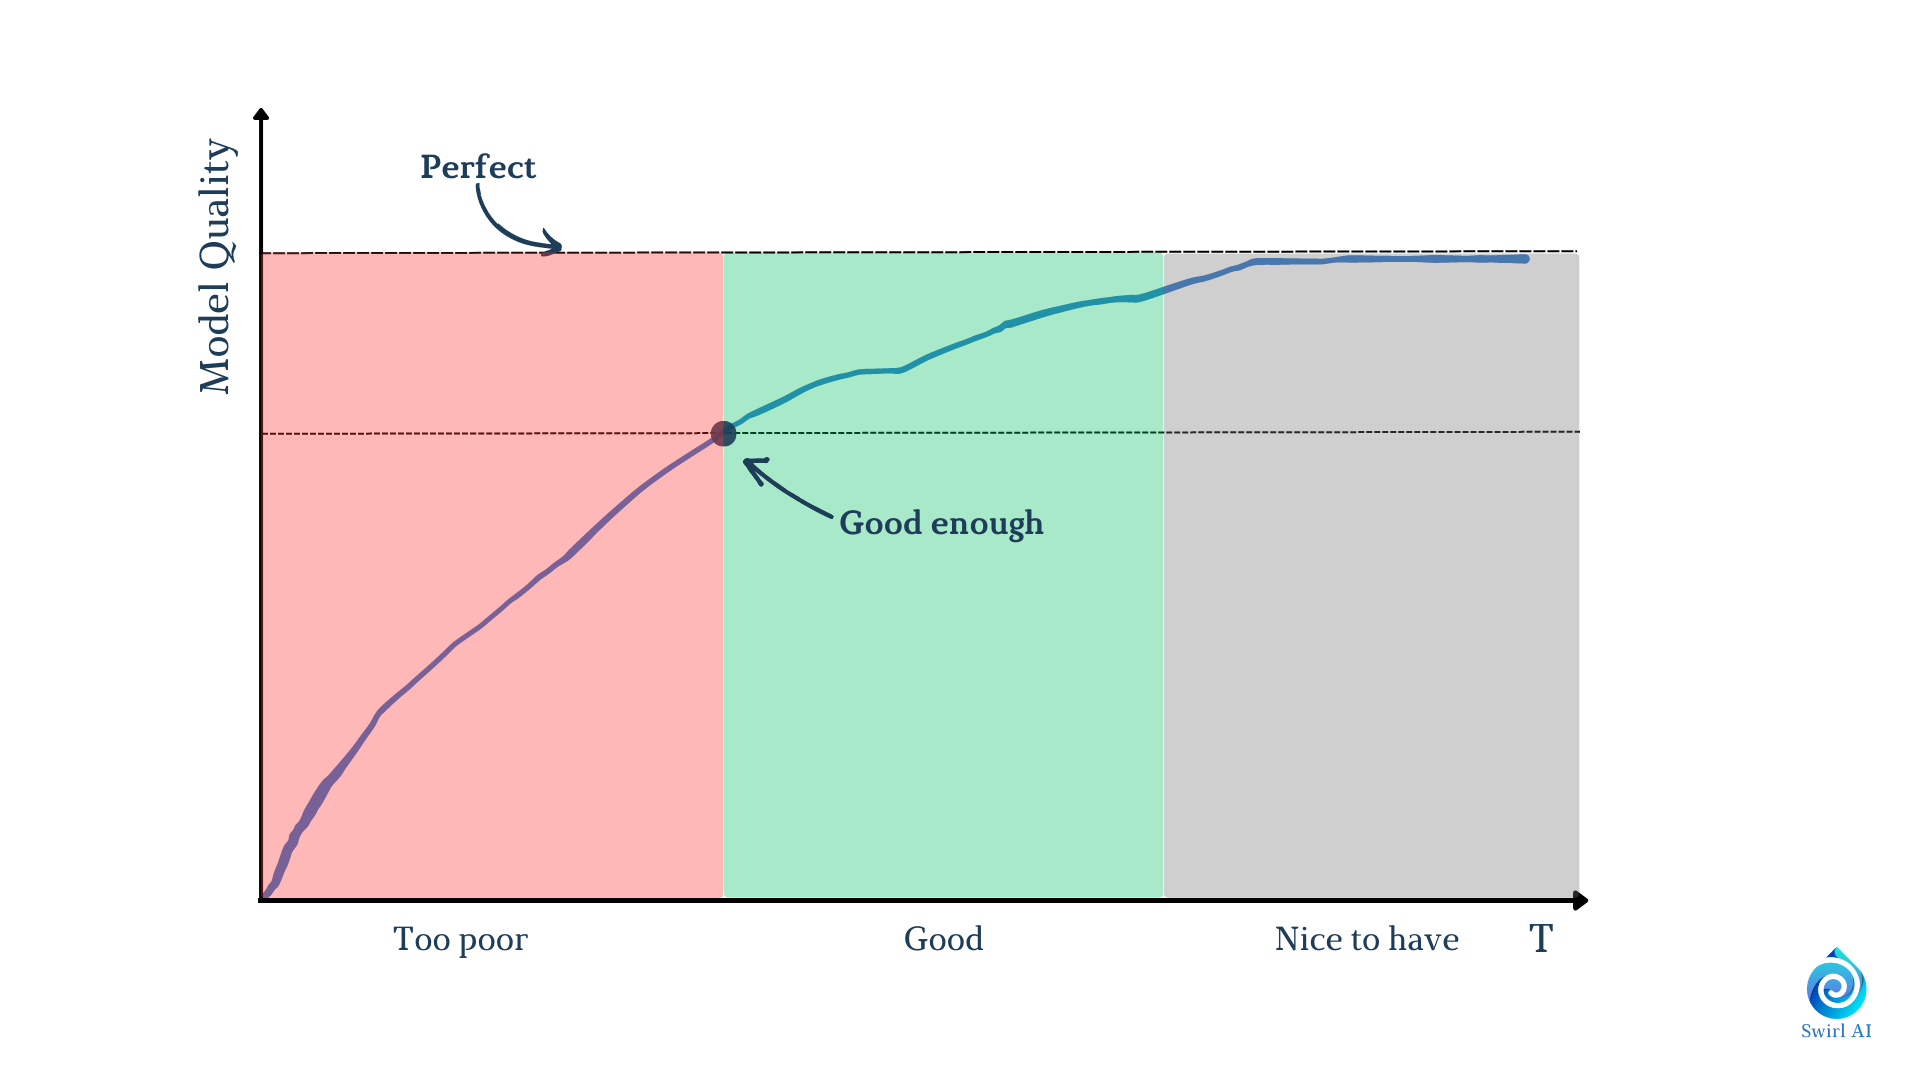

***Good enough***

- Analysis instead of model

- Error of +/- 15% average weekly income

- Features: work days, months, weekdays, hours, city zones, travel duration

### 2.6 Other agreements

# 3. Setup

### 3.1 Importing Python libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
import seaborn as sns


import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')



# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

from scipy import stats
import warnings
warnings.filterwarnings("ignore")

### 3.2 Local library import
We import all the required local libraries libraries

In [2]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries

### 3.3 Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.


# 4. Data


This section should describe the data and datasets that the model requires as input, including the format and any preprocessing steps that are necessary. Describe the data used to train the model, including the source and format of the data, any preprocessing steps that were taken. 

### 4.1 Data collection

https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

***PRICING***

3$ initial charge.

Plus 70 cents per 1/5 mile when traveling above 12mph or per 60 seconds in slow traffic or when the vehicle is stopped.

Plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties.

Plus 1$ Improvement Surcharge.

Plus 1$ overnight surcharge 8pm to 6am.

Plus 2$ rush hour surcharge from 4pm to 8pm on weekdays, excluding holidays.

Plus New York State Congestion Surcharge of 2,75$ (Green Taxi) or 75 cents (any shared ride) for all trips that begin, end or pass through Manhattan south of 96th Street.

Plus tips and any tolls.

There is no charge for extra passengers, luggage or bags, or paying by credit card.

There were ***1162*** drivers on 2022-02

In [3]:
from datetime import date, timedelta

# Define start and end months
start_month = date(2022, 1, 1)
end_month = date(2022, 12, 31)

# Generate list of file names based on pattern
dataset_list = []
while start_month < end_month:
    dataset_list.append("green_tripdata_" + start_month.strftime("%Y-%m") + ".parquet")
    start_month += timedelta(days=31)

df_list = []
for name in dataset_list:
    try:
        df_list.append(pd.read_parquet(f"https://d37ci6vzurychx.cloudfront.net/trip-data/{name}"))
    except Exception as e:
        print(f"Error reading file {name}: {e}")
        
# Create a dataset for green taxis data
raw_green_taxi_data = pd.concat(df_list, ignore_index=True)

In [4]:
# Make copy of rawdataset
green_taxi_data = raw_green_taxi_data.copy()

In [5]:
# Collect data for testing
df_green_taxi_data_examples = [pd.read_parquet(f"https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")]
green_taxi_data_examples = pd.concat(df_green_taxi_data_examples)

In [6]:
# Collect geo data
import geopandas as gpd
from shapely.wkt import loads

# Read in the NYC taxi zones shapefile
nyc_zones = gpd.read_file('taxi_zones/taxi_zones.shp')

# Convert the geometry column to Shapely geometry objects
nyc_zones['geometry'] = nyc_zones['geometry'].apply(lambda x: loads(x.wkt))

In [7]:
import pandas_profiling as pdp

report_green_taxi_data = pdp.ProfileReport(green_taxi_data, title="Report",minimal=True)
#report_green_taxi_data

### 4.2 Data preprocessing

In [8]:
# Extract datetime information
def datetime_info(green_taxi_data):
    green_taxi_data["weekday"] = green_taxi_data.lpep_pickup_datetime.apply(lambda x: x.weekday())
    green_taxi_data["hour"] = green_taxi_data.lpep_pickup_datetime.apply(lambda x: x.hour)
    green_taxi_data["month"] = green_taxi_data.lpep_pickup_datetime.apply(lambda x: x.month)
    green_taxi_data["day_of_year"] = green_taxi_data.lpep_pickup_datetime.apply(lambda x: x.timetuple().tm_yday)
    green_taxi_data["trip_duration_sec"] = (green_taxi_data.lpep_dropoff_datetime - green_taxi_data.lpep_pickup_datetime).astype('timedelta64[s]')
    return green_taxi_data

green_taxi_data = datetime_info(green_taxi_data)

In [9]:
# Remove cancelled trips
green_taxi_data = green_taxi_data[green_taxi_data.trip_duration_sec > 0]

In [10]:
# Calculate speed
green_taxi_data['avg_speed'] = green_taxi_data.trip_distance/green_taxi_data.trip_duration_sec * 3600.0

In [11]:
# Remove trips with average speed > 150
green_taxi_data = green_taxi_data[green_taxi_data.avg_speed < 150]

In [12]:
# Remove trips with negative total amount
green_taxi_data = green_taxi_data[green_taxi_data.total_amount > 0]

In [13]:
# Splitting train and test datasets
from sklearn.model_selection import train_test_split

# Split the dataframe into X (features) and y (target variable)
X = green_taxi_data
y = green_taxi_data['total_amount']

# split the data into training and test datasets
green_taxi_data, test_x, green_taxi_data_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the datasets
print("Training dataset shape: ", green_taxi_data.shape)
print("Test dataset shape: ", test_x.shape)

Training dataset shape:  (666137, 26)
Test dataset shape:  (166535, 26)


In [14]:
green_taxi_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,weekday,hour,month,day_of_year,trip_duration_sec,avg_speed
826764,1,2022-12-28 19:00:57,2022-12-28 19:26:41,N,1.0,14,55,1.0,0.00,20.2,0.0,1.5,0.0,0.0,<NA>,1.0,21.70,1.0,1.0,0.00,2,19,12,362,1544.0,0.000000
399220,2,2022-06-17 10:54:33,2022-06-17 11:00:12,N,1.0,74,75,1.0,1.10,6.0,0.0,0.5,0.0,0.0,<NA>,0.3,6.80,2.0,1.0,0.00,4,10,6,168,339.0,11.681416
636451,1,2022-10-01 02:11:27,2022-10-01 02:17:56,N,1.0,41,74,1.0,1.30,7.0,0.5,0.5,2.0,0.0,<NA>,0.3,10.30,1.0,1.0,0.00,5,2,10,274,389.0,12.030848
36566,2,2022-01-20 22:50:14,2022-01-20 23:05:47,N,1.0,74,142,1.0,4.01,15.0,0.5,0.5,0.0,0.0,<NA>,0.3,19.05,1.0,1.0,2.75,3,22,1,20,933.0,15.472669
381433,2,2022-06-09 12:23:29,2022-06-09 12:33:55,N,1.0,95,160,5.0,1.78,9.0,0.0,0.5,1.2,0.0,<NA>,0.3,11.00,1.0,1.0,0.00,3,12,6,160,626.0,10.236422


### 4.3 Exploratory data analysis

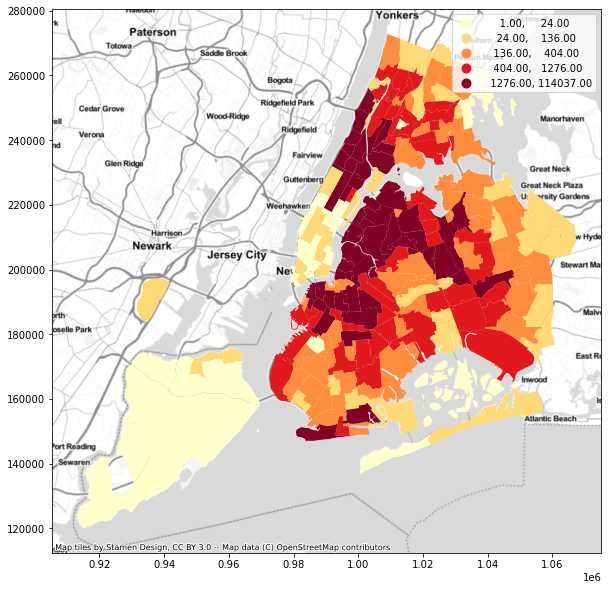

In [15]:
import contextily as ctx

# Group by pickup location and count the number of pickups
pickup_counts = green_taxi_data.groupby(['PULocationID']).size().reset_index(name='count')

# Merge pickup counts with taxi zone polygons
pickup_heatmap = nyc_zones.merge(pickup_counts, left_on='LocationID', right_on='PULocationID')

# Plot the pickup heatmap on top of a basemap
ax = pickup_heatmap.plot(column='count', cmap='YlOrRd', scheme='quantiles', figsize=(10, 10), legend=True)
ctx.add_basemap(ax, crs=pickup_heatmap.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
plt.show()

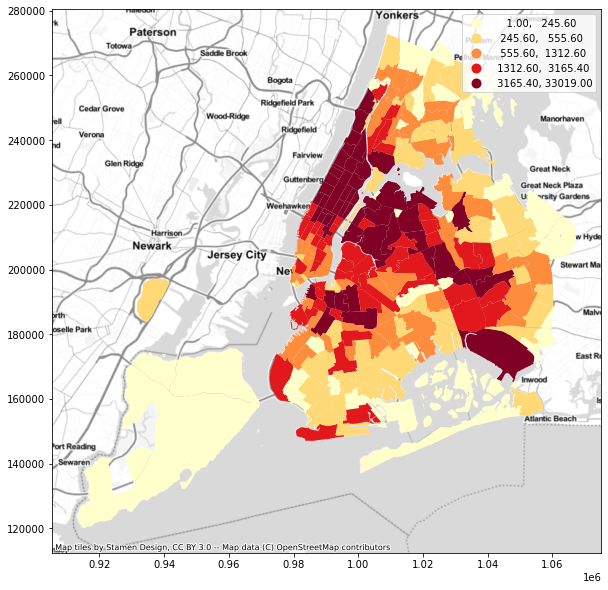

In [16]:
# Group by dropoff location and count the number of dropoff's
dropoff_counts = green_taxi_data.groupby(['DOLocationID']).size().reset_index(name='count')

# Merge pickup counts with taxi zone polygons
dropoff_heatmap = nyc_zones.merge(dropoff_counts, left_on='LocationID', right_on='DOLocationID')

# Plot the pickup heatmap on top of a basemap
ax = dropoff_heatmap.plot(column='count', cmap='YlOrRd', scheme='quantiles', figsize=(10, 10), legend=True)
ctx.add_basemap(ax, crs=pickup_heatmap.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
plt.show()

In [17]:
green_taxi_dayofyear = green_taxi_data.groupby('day_of_year').size().reset_index(name='tripnum_day_green')

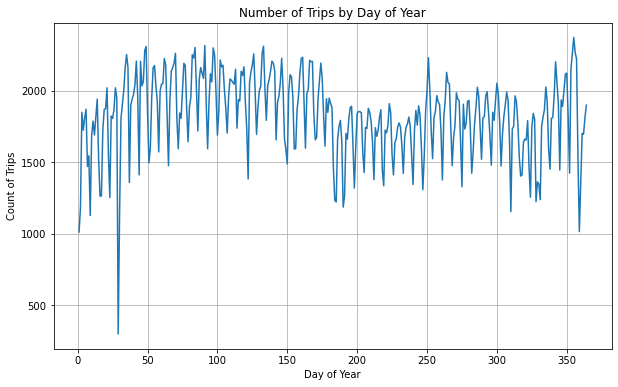

In [18]:
# Plotting 'day_of_year' vs count of trips
plt.plot(green_taxi_dayofyear['day_of_year'][:-1], green_taxi_dayofyear['tripnum_day_green'][:-1])
plt.xlabel('Day of Year')
plt.ylabel('Count of Trips')
plt.title('Number of Trips by Day of Year')
plt.grid(True)
plt.show()

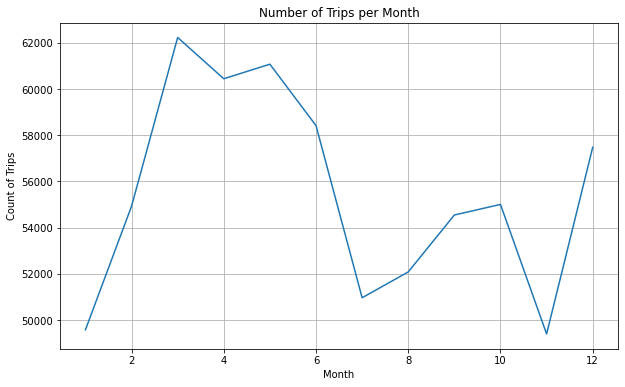

In [19]:
# Group by month and count the number of trips per month
trips_per_month = green_taxi_data.groupby('month').size()

# Plotting count of trips per month
plt.figure(figsize=(10, 6))
plt.plot(trips_per_month.index, trips_per_month.values)
plt.xlabel('Month')
plt.ylabel('Count of Trips')
plt.title('Number of Trips per Month')
plt.grid(True)
plt.show()


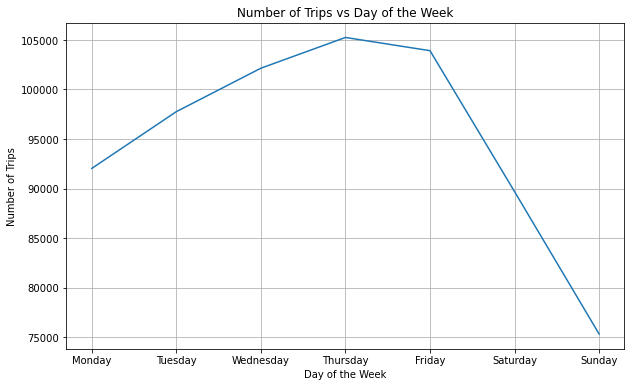

In [20]:
# Group by day of the week and count the number of trips per day
trips_per_day_of_week = green_taxi_data.groupby('weekday').size()

# Define the names of the days of the week for labeling
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting number of trips vs day of the week
plt.figure(figsize=(10, 6))
plt.plot(day_names, trips_per_day_of_week)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips vs Day of the Week')
plt.grid(True)
plt.show()


In [21]:
# Create morning, afternoon and night shifts
# Define shift boundaries
shift_boundaries = [pd.Timestamp('06:00:00'), pd.Timestamp('14:00:00'), pd.Timestamp('22:00:00'), pd.Timestamp('23:59:59') + pd.Timedelta(seconds=1)]

# Define shift labels
shift_labels = ['Morning', 'Afternoon', 'Night']

# Create the 'shift' column
green_taxi_data['shift'] = np.select([green_taxi_data['lpep_pickup_datetime'].dt.time.between(shift_boundaries[i].time(), shift_boundaries[i+1].time()) for i in range(len(shift_boundaries)-1)],
                                    shift_labels, default='Night')

# Group data and calculate counts per shift per weekday
grouped_data = green_taxi_data.groupby(['weekday', 'shift']).size().unstack().fillna(0)


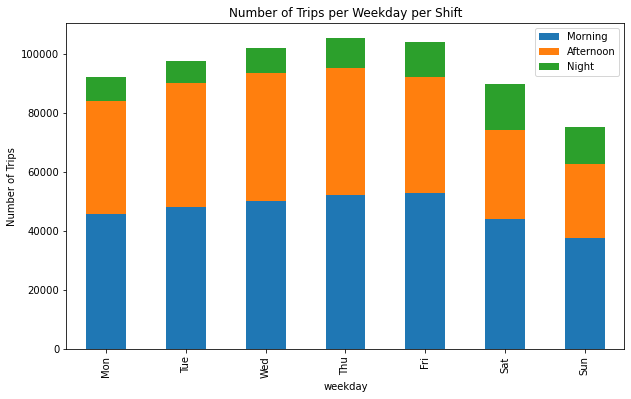

In [22]:
# Group the data by weekday and shift and count the number of trips
trips_per_weekday_shift = green_taxi_data.groupby(['weekday', 'shift']).size().unstack()

# Define the shift labels
shift_labels = ['Morning', 'Afternoon', 'Night']

# Plot the number of trips per weekdays per shifts
trips_per_weekday_shift.plot(kind='bar', stacked=True)

# Set the x-axis labels
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Set the y-axis label
plt.ylabel('Number of Trips')

# Set the title
plt.title('Number of Trips per Weekday per Shift')

# Set the legend
plt.legend(shift_labels)

# Show the plot
plt.show()


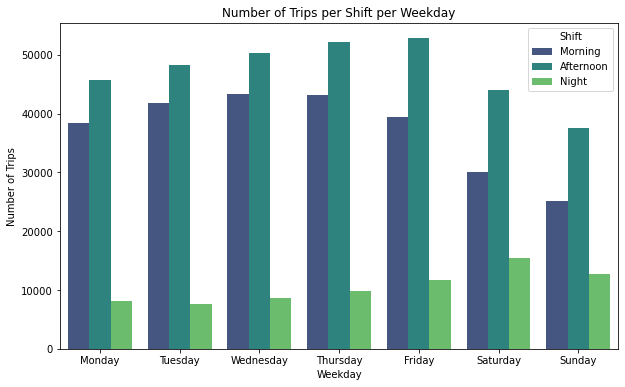

In [23]:
# Create a DataFrame with all possible combinations of weekday and shift
combinations = pd.MultiIndex.from_product([range(7), ['Morning', 'Afternoon', 'Night']], names=['weekday', 'shift'])
grouped_data = green_taxi_data.groupby(['weekday', 'shift']).size().reindex(combinations, fill_value=0).reset_index(name='count')

# Define the weekdays
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the grouped bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='weekday', y='count', hue='shift', palette='viridis')

# Set the labels and title
plt.xlabel('Weekday')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Shift per Weekday')

# Set the x-axis tick labels
plt.xticks(range(7), weekday_names)

# Add a legend
plt.legend(title='Shift')

# Show the plot
plt.show()


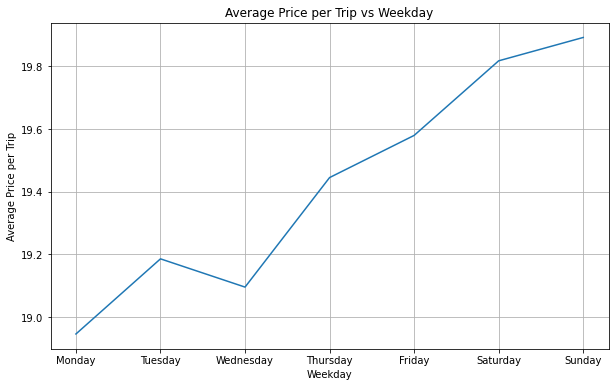

In [24]:
# Group by weekday and calculate the average price per trip
avg_price_per_weekday = green_taxi_data.groupby('weekday')['total_amount'].mean()

# Define the names of the weekdays for labeling
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting average price per trip vs weekday
plt.plot(weekday_names, avg_price_per_weekday)
plt.xlabel('Weekday')
plt.ylabel('Average Price per Trip')
plt.title('Average Price per Trip vs Weekday')
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Number of trips per hour conditioned on weekday for NYC green taxi')

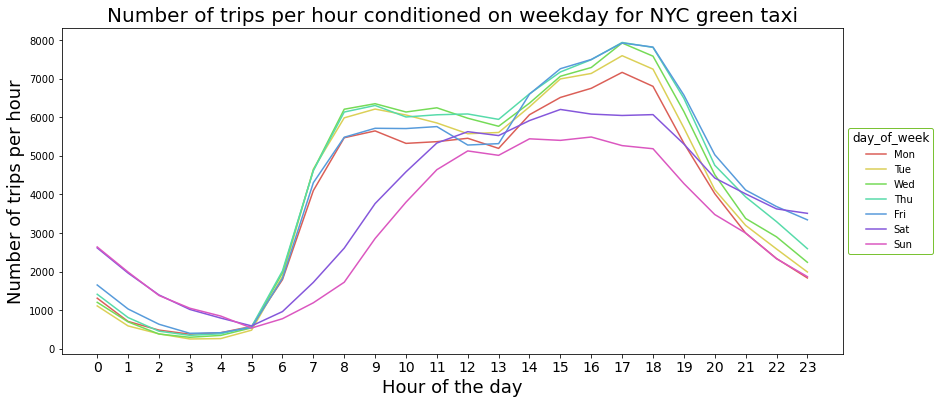

In [25]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
trips_per_weekday_hour = green_taxi_data.groupby(['weekday', 'hour']).size().reset_index(name='count')
sns.lineplot(x = 'hour', y = 'count', hue = 'weekday',data = trips_per_weekday_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.xticks(size=14)
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Number of trips per hour conditioned on weekday for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Average price per hour conditioned on weekday for NYC green taxi')

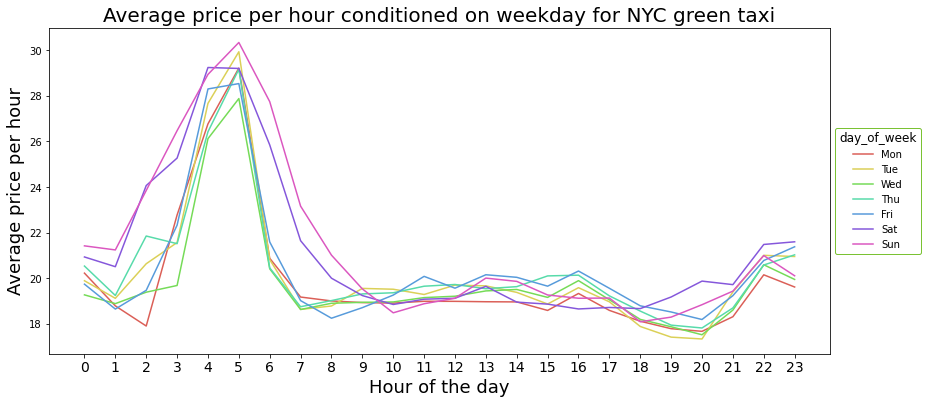

In [26]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
amount_per_weekday_hour = green_taxi_data.groupby(['weekday', 'hour'])['total_amount'].mean().reset_index(name='avg_price')
sns.lineplot(x = 'hour', y = 'avg_price', hue = 'weekday',data = amount_per_weekday_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.xticks(size=14)
plt.ylabel('Average price per hour', fontsize = 18)
plt.title('Average price per hour conditioned on weekday for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Average trip duration per hour conditioned on weekday for NYC green taxi')

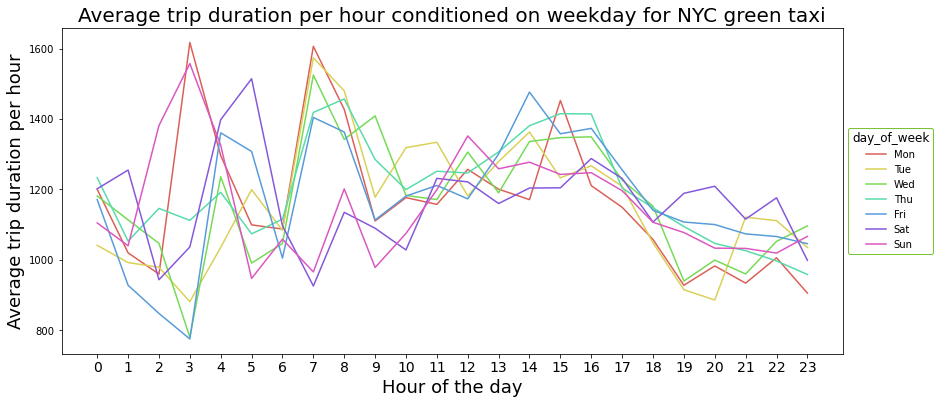

In [27]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
avg_duration_per_weekday_hour = green_taxi_data.groupby(['weekday', 'hour'])['trip_duration_sec'].mean().reset_index(name='avg_duration')
sns.lineplot(x = 'hour', y = 'avg_duration', hue = 'weekday',data = avg_duration_per_weekday_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.xticks(size=14)
plt.ylabel('Average trip duration per hour', fontsize = 18)
plt.title('Average trip duration per hour conditioned on weekday for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Average trip speed per hour conditioned on weekday for NYC green taxi')

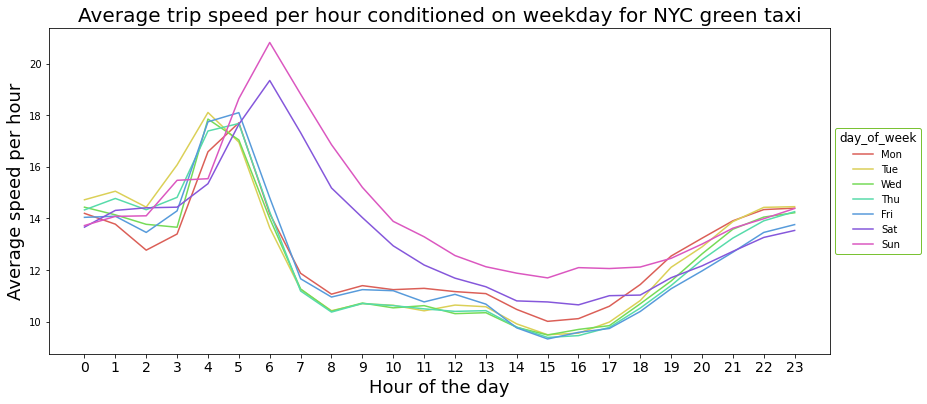

In [28]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
avg_speed_per_weekday_hour = green_taxi_data.groupby(['weekday', 'hour'])['avg_speed'].mean().reset_index(name='m_avg_speed')
sns.lineplot(x = 'hour', y = 'm_avg_speed', hue = 'weekday',data = avg_speed_per_weekday_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#59b300', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24), size=14)
plt.xticks(size=14)
plt.ylabel('Average speed per hour', fontsize = 18)
plt.title('Average trip speed per hour conditioned on weekday for NYC green taxi', fontsize = 20)

Text(0.5, 1.0, 'Scatter plot for trip distance vs trip duration in sec')

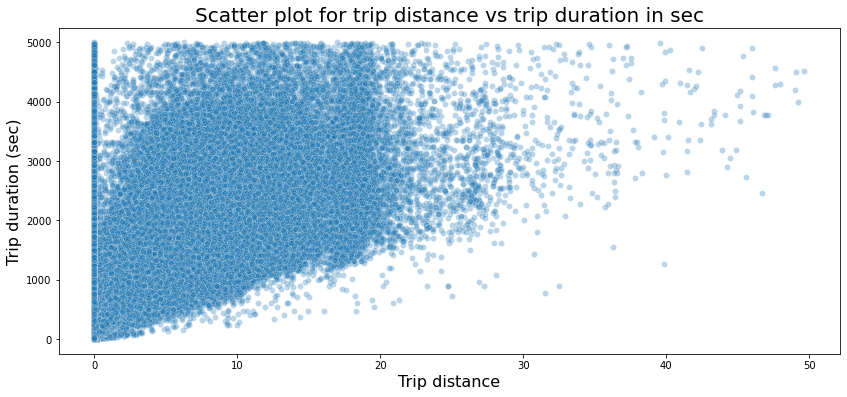

In [29]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
green_taxi_data_scatter = green_taxi_data[(green_taxi_data.trip_distance <= 50) & (green_taxi_data.trip_duration_sec <= 5000)]
sns.scatterplot(x="trip_distance", y="trip_duration_sec", data=green_taxi_data_scatter, alpha = 0.3, ax = ax)
plt.xlabel('Trip distance', fontsize=16)
plt.ylabel('Trip duration (sec)', fontsize = 16)
plt.title('Scatter plot for trip distance vs trip duration in sec', fontsize = 20)

In [30]:
cor_1 = stats.pearsonr(green_taxi_data_scatter.trip_distance, green_taxi_data_scatter.trip_duration_sec)
print('Pearson correlation for trip distance and trip duration for NYC green taxi data: {:.3f}'.format(cor_1[0]))

Pearson correlation for trip distance and trip duration for NYC green taxi data: 0.690


Text(0.5, 1.0, 'Scatter plot for trip distance vs total amount')

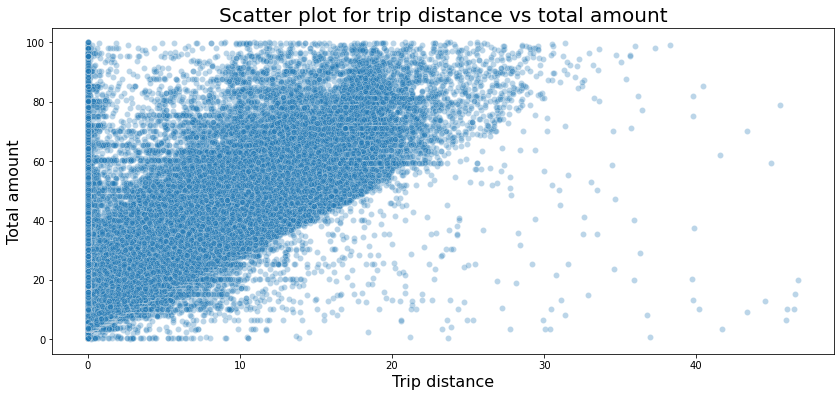

In [31]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
green_taxi_data_scatter_1 = green_taxi_data[(green_taxi_data.trip_distance <= 50) & (green_taxi_data.total_amount <= 100)]
sns.scatterplot(x="trip_distance", y="total_amount", data=green_taxi_data_scatter_1, alpha = 0.3, ax = ax)
plt.xlabel('Trip distance', fontsize=16)
plt.ylabel('Total amount', fontsize = 16)
plt.title('Scatter plot for trip distance vs total amount', fontsize = 20)

In [32]:
cor_2 = stats.pearsonr(green_taxi_data_scatter_1.trip_distance, green_taxi_data_scatter_1.total_amount)
print('Pearson correlation for trip distance and trip duration for NYC green taxi data: {:.3f}'.format(cor_2[0]))

Pearson correlation for trip distance and trip duration for NYC green taxi data: 0.789


### 4.4 Feature engineering

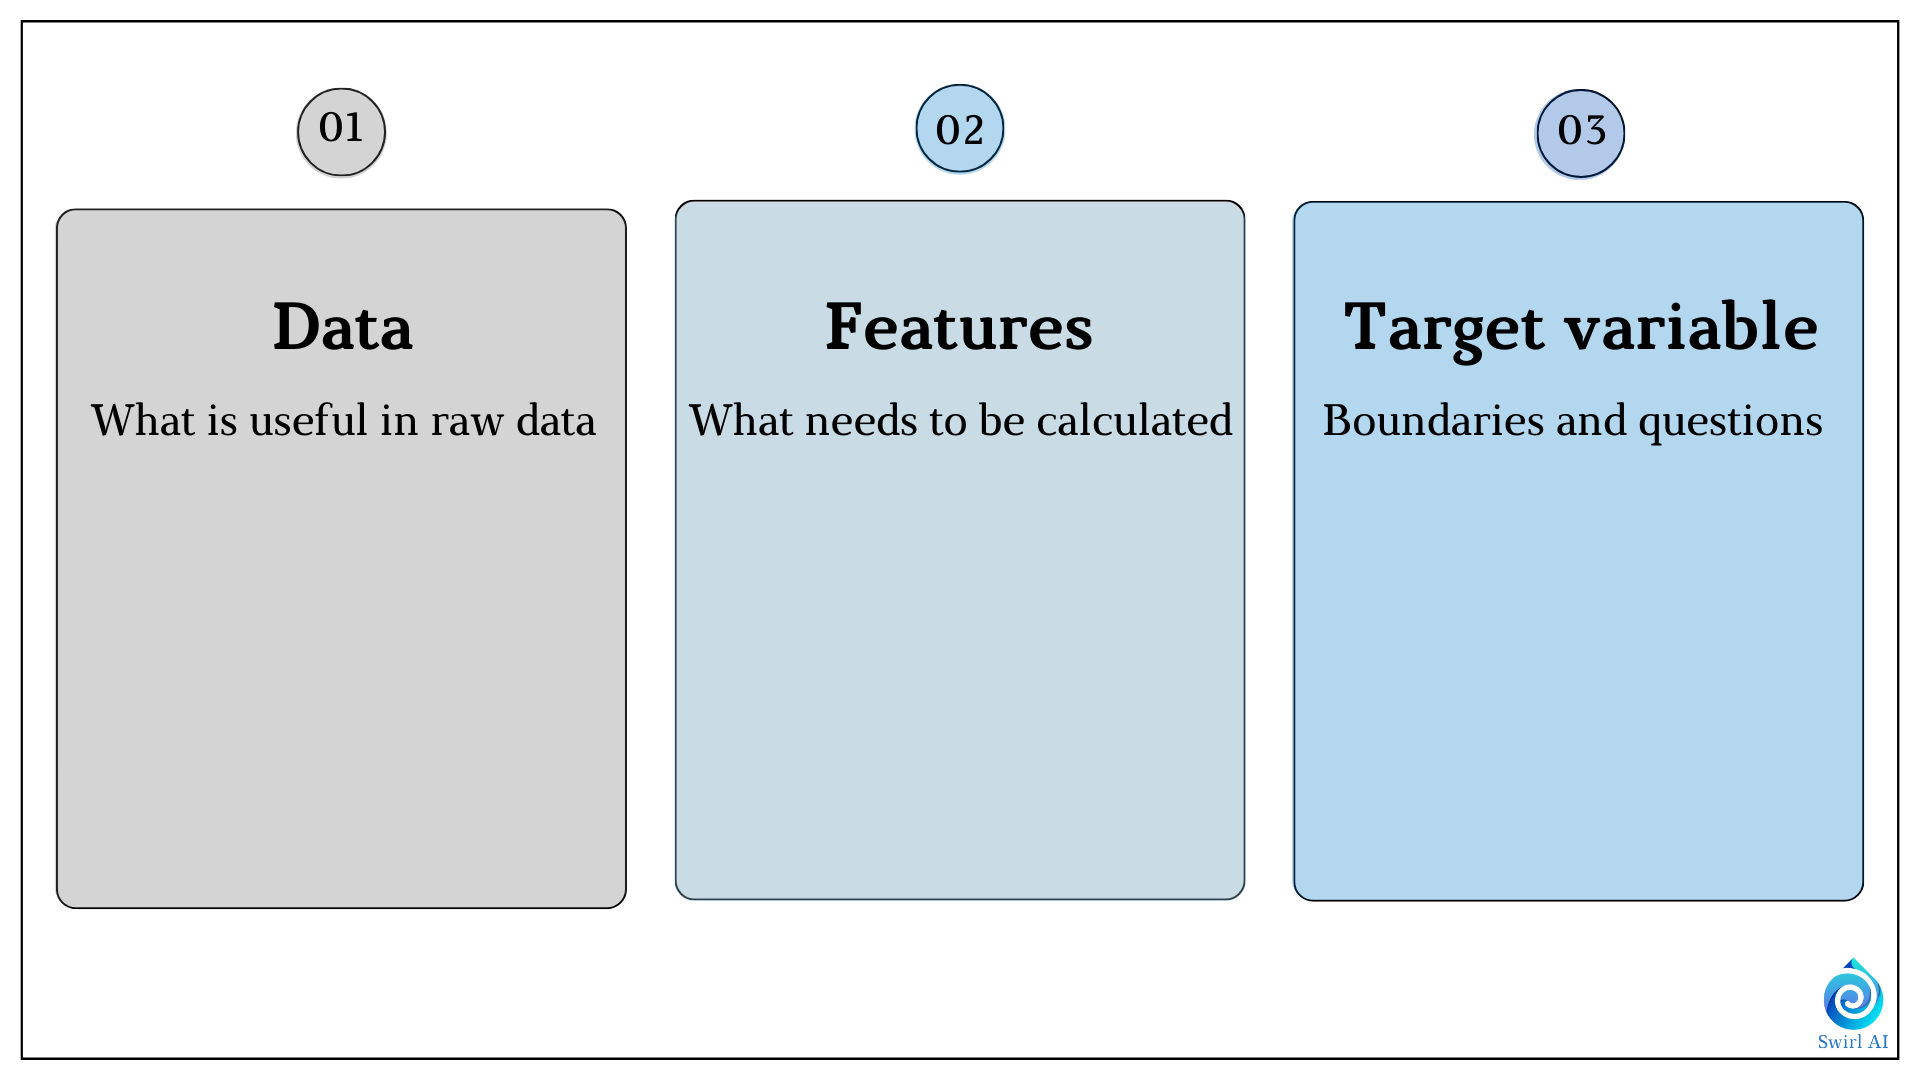

In [33]:
green_taxi_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,weekday,hour,month,day_of_year,trip_duration_sec,avg_speed,shift
826764,1,2022-12-28 19:00:57,2022-12-28 19:26:41,N,1.0,14,55,1.0,0.00,20.2,0.0,1.5,0.0,0.0,<NA>,1.0,21.70,1.0,1.0,0.00,2,19,12,362,1544.0,0.000000,Afternoon
399220,2,2022-06-17 10:54:33,2022-06-17 11:00:12,N,1.0,74,75,1.0,1.10,6.0,0.0,0.5,0.0,0.0,<NA>,0.3,6.80,2.0,1.0,0.00,4,10,6,168,339.0,11.681416,Morning
636451,1,2022-10-01 02:11:27,2022-10-01 02:17:56,N,1.0,41,74,1.0,1.30,7.0,0.5,0.5,2.0,0.0,<NA>,0.3,10.30,1.0,1.0,0.00,5,2,10,274,389.0,12.030848,Night
36566,2,2022-01-20 22:50:14,2022-01-20 23:05:47,N,1.0,74,142,1.0,4.01,15.0,0.5,0.5,0.0,0.0,<NA>,0.3,19.05,1.0,1.0,2.75,3,22,1,20,933.0,15.472669,Night
381433,2,2022-06-09 12:23:29,2022-06-09 12:33:55,N,1.0,95,160,5.0,1.78,9.0,0.0,0.5,1.2,0.0,<NA>,0.3,11.00,1.0,1.0,0.00,3,12,6,160,626.0,10.236422,Morning


In [34]:
# Calculate average amount (price) per min that driver might get each shift hour depending on a weekday
green_taxi_data['duration_minutes'] = (green_taxi_data['lpep_dropoff_datetime'] - green_taxi_data['lpep_pickup_datetime']).dt.total_seconds() / 60
average_amount_per_minute = green_taxi_data.groupby(['weekday', 'shift'])['total_amount'].mean() / green_taxi_data.groupby(['weekday', 'shift'])['duration_minutes'].mean()
average_amount_per_minute = average_amount_per_minute.reset_index(name='average_amount_per_minute')

In [35]:
shifts = ['Morning', 'Afternoon', 'Night']
weekdays = ['0', '1', '2', '3', '4', '5', '6']

combinations = [(weekday, shift) for weekday in weekdays for shift in shifts]

demand_data = pd.DataFrame(combinations, columns=['weekday', 'shift'])

# Calculate the count of trips per shift per weekday
demand_data['count'] = green_taxi_data.groupby(['weekday', 'shift']).size().values

# Define the number of drivers per shift
num_drivers = {'Morning': 700, 'Afternoon': 700, 'Night': 300}

# Calculate demand as count of trips divided by number of drivers
demand_data['num_drivers'] = demand_data['shift'].map(num_drivers)
demand_data['demand'] = demand_data['count'] / demand_data['num_drivers']

In [36]:
# Convert 'weekday' column in demand_data to int64 type
demand_data['weekday'] = demand_data['weekday'].astype(int)

# Merge average_amount_per_minute onto demand_data
demand_data_merged = pd.merge(demand_data, average_amount_per_minute, on=['weekday', 'shift'])


# Reset the index
demand_data_merged = demand_data_merged.reset_index(drop=True)

In [37]:
# Define a list of weekday names
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Rename the weekdays in demand_data
demand_data_merged['weekday'] = demand_data_merged['weekday'].map(lambda x: weekday_names[x])


In [38]:
# The average duration for trip is 20 mins and drivers have to get to their customers, 
# On average there might have around 2 trips per hour. That sums to 16 trips per shift.

demand_data_merged['earnings_per_shift'] = demand_data_merged['demand']*demand_data_merged['average_amount_per_minute']*16

In [39]:
demand_data_merged.head()

,weekday,shift,count,num_drivers,demand,average_amount_per_minute,earnings_per_shift
0,Monday,Morning,45628,700,65.182857,0.911456,950.580428
1,Monday,Afternoon,38358,700,54.797143,0.976564,856.207002
2,Monday,Night,8049,300,26.830000,1.179899,506.507253
3,Tuesday,Morning,48274,700,68.962857,0.883626,974.997597
4,Tuesday,Afternoon,41827,700,59.752857,0.974036,931.223286


### 4.5 Datasets formed



**Raw data** - raw_green_taxi_data

**Exploratory data** - green_taxi_data

**Test data** - test_x, test_y

**Validation data** - green_taxi_data_examples


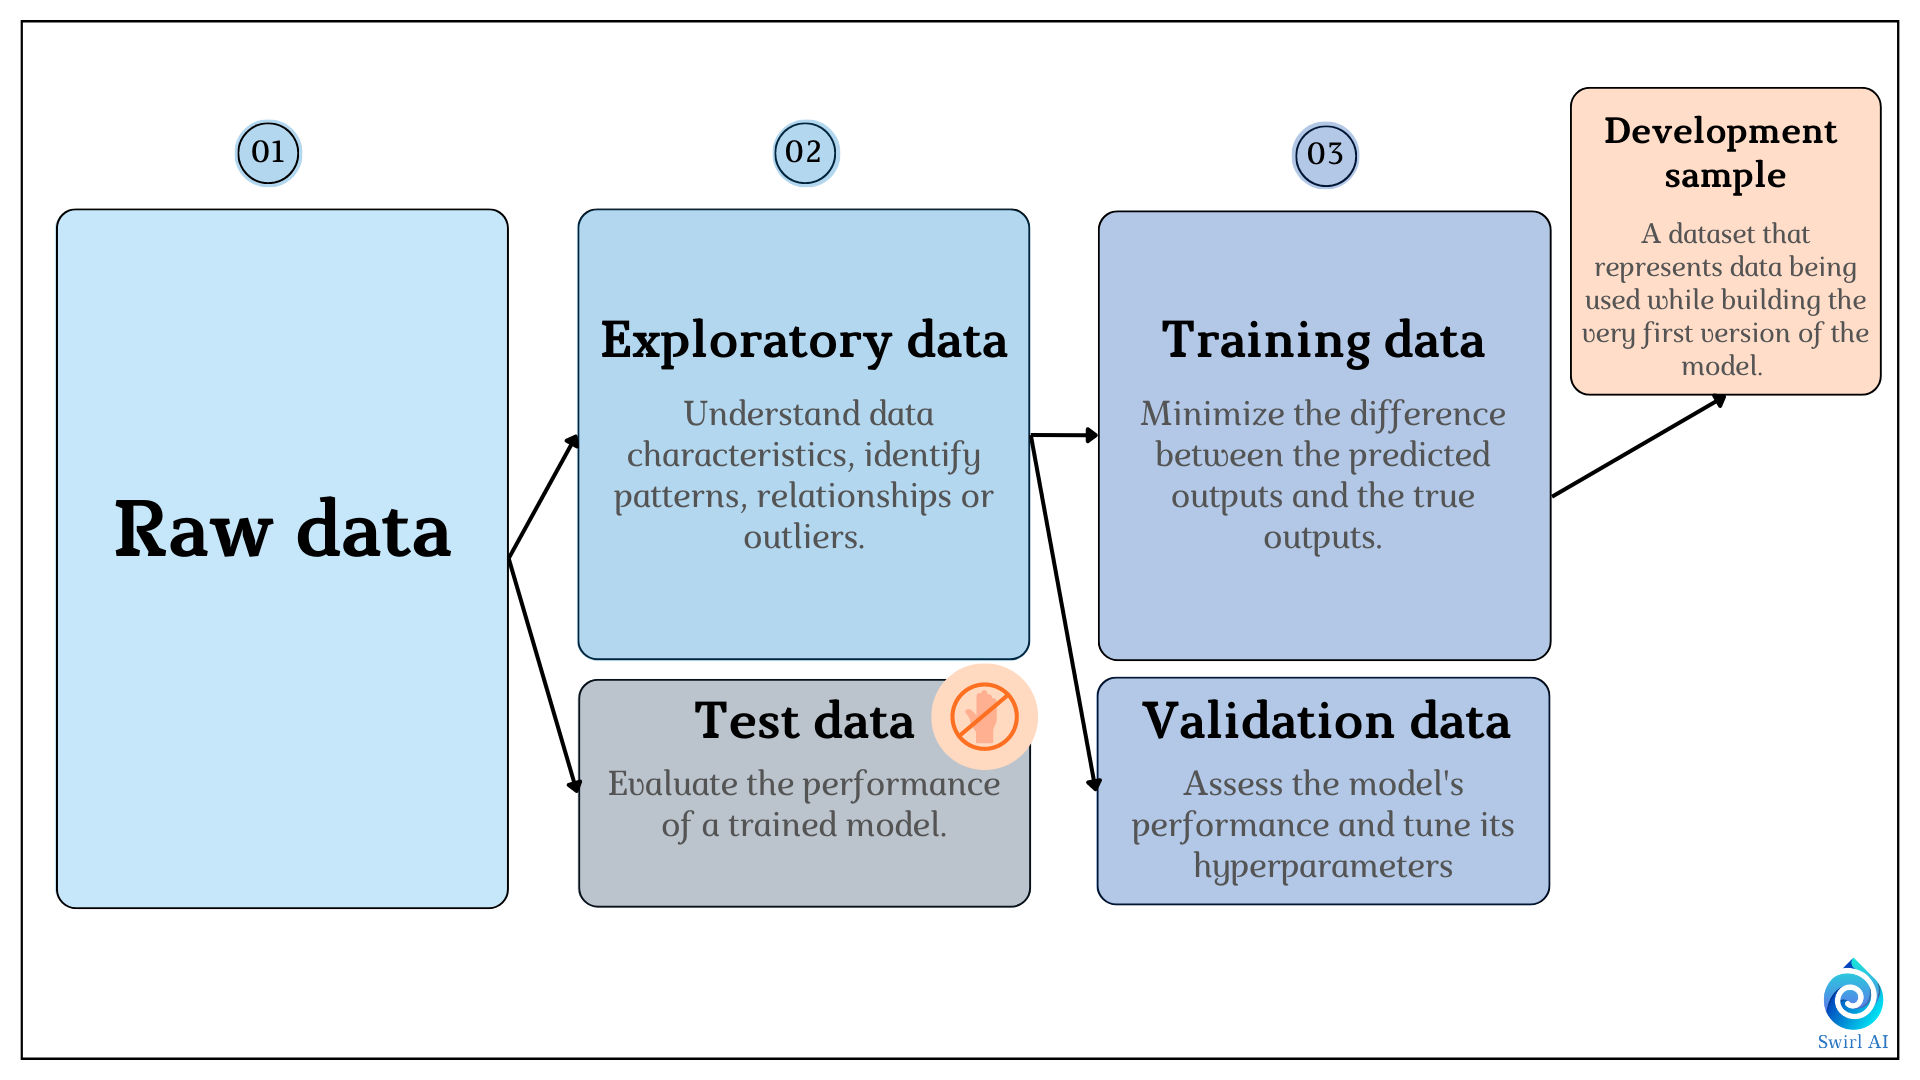

# 5. Model

### 5.1 Reasoning for selected algorithm(s)

### 5.2 Features and hyperparameters

### 5.3 Model

# 6. Model validation & Test

### 6.1 Metrics for model validation

### 6.2 Limitations of the model

### 6.3 Test results

### 6.4 Bias, fairness and other ethical considerations

# 7. Deployment

### 7.1 Platform, infrastructure and tools used

### 7.2 Model deployment

### 7.3 Model's architecture

### 7.4 Model maintenance and monitoring

### 7.5 Security considerations

# 8. Ongoing questions

# 9. Ideas for improvement

- Build a feature that would allow to pick more profitable trips
- Add weather datas as a feature
- Add seasonality and holidays

# 10. Material for meetings